In [1]:
# Goal: We want to predict who will experience financial distress in the next two years. 
# For this assignment, I assume that a loan-lending company has limited resources and would like to 
# know which individuals to check in with to determine solutions/know which loans are more likley to
# default in advance.
# The company can only check in with 20 individuals per week. Which individuals should the company reach out to?
# Thus, we are interesting in precision in our top 20.

# To-Do: Create function that finds best prob_a cut-off-value.
# Use validation curve function.
import re
import os.path
import random
import pydotplus
from time import time
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import custom modules
import exploration
import preprocess
import predictions

In [3]:
#ML imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn import tree

In [4]:
#Notebook commands
from IPython.display import Image  
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

## Tasks:

1. Read Data: For this assignment, assume input is CSV and write a function that can read a csv into python

2. Explore Data: You can use the code you wrote for assignment 1 here to generate distributions and data summaries.

3. Pre-Process Data: For this assignment, you can limit this to filling in missing values for the variables that have missing values. You can use any simple method to do it (use mean to fill in missing values).

4. Generate Features/Predictors: For this assignment, you should write one function that can discretize a continuous variable and one function that can take a categorical variable and create binary/dummy variables from it. Apply them to at least one variable each in this data.

5. Build Classifier: For this assignment, select any classifier you feel comfortable with (Logistic Regression for example)

6. Evaluate Classifier: you can use any metric you choose for this assignment (accuracy is the easiest one). Feel free to evaluate it on the same data you built the model on (this is not a good idea in general but for this assignment, it is fine). We haven't covered models and evaluation yet, so don't worry about creating validation sets or cross-validation. 

In [5]:
X_train, X_test, y_train, y_test = exploration.read_data_from_csv("data/credit-data.csv", 0, 
                                                                  True, "SeriousDlqin2yrs", 0.33)
data = X_train.join(y_train)
data.head()

,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
PersonID,,,,,,,,,,,,
87936,0.000000,68,60804,0,798.000000,NaN,4,0,1,0,0.0,0
3893,1.000000,34,60644,0,0.058946,4325.0,2,0,0,0,0.0,0
41405,1.000666,39,60637,0,1911.000000,NaN,5,0,2,0,0.0,0
91125,0.653085,52,60629,0,0.203020,4900.0,10,0,0,0,2.0,0
67373,1.000000,54,60625,3,779.000000,NaN,5,2,1,2,NaN,1


----
# Exploring data

In [6]:
# General description of data.
print("Dimension of train dataset: {} rows and {} features.\n".format(data.shape[0], data.shape[1]))
data.describe()

Dimension of train dataset: 100500 rows and 12 features.



,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
count,100500.000000,100500.000000,100500.000000,100500.000000,100500.000000,8.066300e+04,100500.000000,100500.000000,100500.000000,100500.000000,97874.000000,100500.000000
mean,5.459191,52.281841,60648.638239,0.435910,349.759787,6.637161e+03,8.457473,0.279174,1.018478,0.252667,0.759109,0.067393
std,210.022307,14.780930,56.640170,4.335404,1782.139436,1.193133e+04,5.141521,4.313026,1.120661,4.298975,1.118766,0.250703
min,0.000000,21.000000,60601.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029980,41.000000,60625.000000,0.000000,0.175145,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.155435,52.000000,60629.000000,0.000000,0.366655,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.560897,63.000000,60644.000000,0.000000,0.868521,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000,0.000000
max,29110.000000,109.000000,60804.000000,98.000000,307001.000000,1.794060e+06,57.000000,98.000000,32.000000,98.000000,13.000000,1.000000


In [7]:
# What is the distribution of our target variable?
data.SeriousDlqin2yrs.value_counts()
data.SeriousDlqin2yrs.value_counts(normalize=True)

0    93727
1     6773
Name: SeriousDlqin2yrs, dtype: int64

0    0.932607
1    0.067393
Name: SeriousDlqin2yrs, dtype: float64

We are trying to predict who experiences 90 days past due delinquency or worse. In our dataset, this only occurs in 6.6% of the cases.

60625    0.223662
60618    0.112209
60629    0.111731
60637    0.111711
60601    0.111055
60644    0.110100
60804    0.110100
60657    0.109433
Name: zipcode, dtype: float64

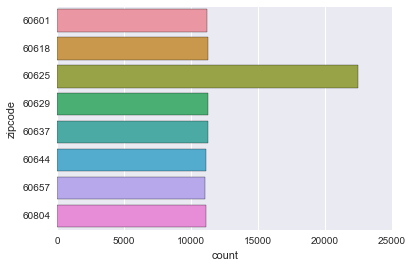

In [8]:
# Are ZIP codes equally represented?
data.zipcode.value_counts(normalize=True)
_ = sns.countplot(y="zipcode", data=data)

We only have data from 8 zip codes. The data looks equally distributed across zip codes, except for 60625 being responsible for 22% of the entries.

In [9]:
# How is our target variable distributed by ZIP code?
cross_table = pd.crosstab(data.zipcode, data.SeriousDlqin2yrs)
cross_table["total"] = cross_table[0] + cross_table[1]
cross_table["perc_of_SeriousDlqin2yrs"] = cross_table[1] / cross_table["total"]
cross_table

SeriousDlqin2yrs,0,1,total,perc_of_SeriousDlqin2yrs
zipcode,,,,
60601,10424,737,11161,0.066034
60618,10530,747,11277,0.066241
60625,20969,1509,22478,0.067132
60629,10502,727,11229,0.064743
60637,10469,758,11227,0.067516
60644,10294,771,11065,0.069679
60657,10250,748,10998,0.068012
60804,10289,776,11065,0.070131


While the ZIP code 60625 has the most entries in the dataset, the relative rate of individuals experiencing 90 days past due delinquency or worse is relatively stable across all ZIP codes.

In [10]:
# What is the mean of a variable for target = 1 and target = 0?
data.groupby("SeriousDlqin2yrs").mean()

,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,,,,,,,,,,,
0,5.574359,52.747415,60648.569164,0.284262,353.424513,6716.737005,8.497786,0.136684,1.020656,0.128159,0.746169
1,3.865456,45.839067,60649.594124,2.534475,299.046113,5581.459851,7.899601,2.250997,0.988336,1.975639,0.936673


On average, individuals experiencing 90 days past due delinquency or worse ...
    - are younger (45.8 vs 52.75)
    - have a lower income (5581 vs 6716)
    - have a lower debt ratio (299 vs 353). However, these means are likely influenced by outliers or come from cases without monthly income/ with no reported income. Therefore, this comparison only holds if we assume that no income/no reported income shows same distribution across target variable.
    - have a lower amount of open credit lines and loans (7.89 vs 8.5)
    - have more dependents (0.94 vs 0.75)
    - have been more often 30-59/60-89/90 days past due but no worse in the last 2 years.

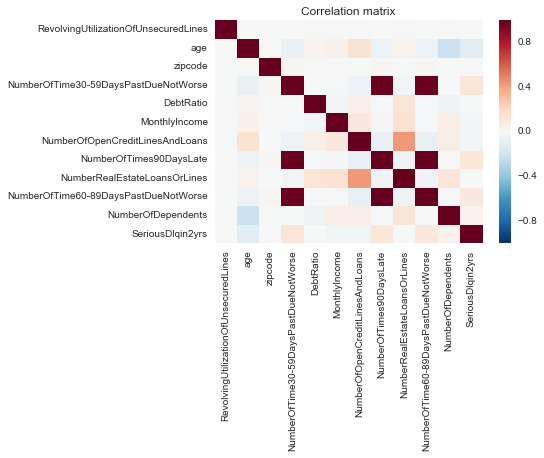

In [11]:
# How are the variables correlated with each other?
exploration.plot_correlations(data, 'Correlation matrix')

_Answer:_ 

There is a __moderate__ positive correlation between our target variable _SeriousDlqin2yrs_ and:
    - NumberOfTime30-59DaysPastDueNotWorse
    - NumberOfTime60-89DaysPastDueNotWorse
    - NumberOfTime90DaysLate
    
There is a __small__ positive correlation between our target variable _SeriousDlqin2yrs_ and:
    - NumberOfDependents
   
There is a __small__ negative correlation between our target variable _SeriousDlqin2yrs_ and:
    - age

----
# Pre-Processing

In [12]:
data.head()

,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
PersonID,,,,,,,,,,,,
87936,0.000000,68,60804,0,798.000000,NaN,4,0,1,0,0.0,0
3893,1.000000,34,60644,0,0.058946,4325.0,2,0,0,0,0.0,0
41405,1.000666,39,60637,0,1911.000000,NaN,5,0,2,0,0.0,0
91125,0.653085,52,60629,0,0.203020,4900.0,10,0,0,0,2.0,0
67373,1.000000,54,60625,3,779.000000,NaN,5,2,1,2,NaN,1


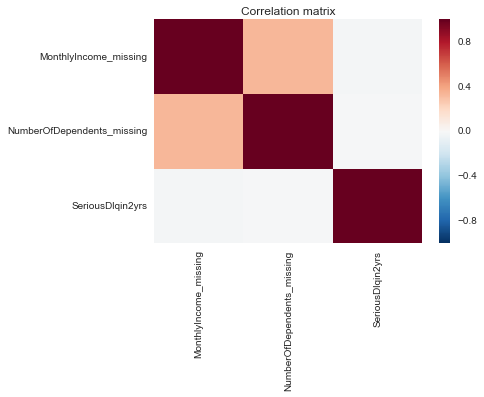

In [13]:
new_columns = preprocess.keep_track_of_missing_values(data, "_missing")
data = preprocess.fill_missing_values_with_mean(data)

#Are the missing values correlated with our target?
exploration.plot_correlations(data[new_columns + ["SeriousDlqin2yrs"]], 'Correlation matrix')

There is no correlation between missing values and our target _SeriousDlqin2yrs_.

----
# Building Features

In [14]:
# setting test's zipcode as category with attributes from train to ensure 
# same columns in train and test set.
X_test["zipcode"] = X_test["zipcode"].astype('category', categories=X_train.zipcode.unique())

# We will use this code to identify discretized dummy vars
dummy_code = "_XX_disc"

# modifying variables
data = preprocess.dummify_var(data, ["zipcode"])
data = preprocess.discretize_cont_var(data, "age", 10, dummy_code)

----
# Preprocessing Test Set

In [15]:
#We will use the preprocessed data as training data
X_train = data.drop(["SeriousDlqin2yrs"], axis=1)

In [16]:
# Do we have similar % of target in train and test?
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

0    0.932607
1    0.067393
Name: SeriousDlqin2yrs, dtype: float64

0    0.934283
1    0.065717
Name: SeriousDlqin2yrs, dtype: float64

In [17]:
# ensuring that X_test has the same columns as X_train
X_test = preprocess.dummify_var(X_test, ["zipcode"])
col_to_value_dict = preprocess.build_col_to_value_dict(X_train, dummy_code)
X_test = preprocess.insert_discretize_quantiles(X_test, col_to_value_dict)

#keeping track of missing values (but only in same columns as train data)
preprocess.create_missing_value_colum_in_testset(X_train, X_test, "_missing")

#fill empty values
X_test = preprocess.fill_missing_values_with_mean(X_test)

----
# Training Classifier

In [18]:
# It is unlikely that an individual is delinquent. 
# How well can we predict if we randomly predict 
# according to mean of training data?
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, 
                                                                    test_size=0.3, random_state=0)
AvgPred = predictions.Average_Predictor()
AvgPred.fit(y_train_val)
AvgPred.score(X_test_val, y_test_val, 'accuracy')
AvgPred.score(X_test_val, y_test_val, 'precision')

0.87512437810945276

0.06898238747553816

When we only predict that an individual is delinquent according to the probability of delinquency (predict delinquency when random number is less than mean of y_train_val), we achieve an accuracy of 0.87 on our hold-out set from the training data. Using the same approach we achieve a precision of 0.062 -> of all the cases where our algorithm says that the individual will face financial problems, only 6% of the individuals actually face financial problems.

In [19]:
RandomPred = predictions.Average_Predictor()
RandomPred.fit(np.array([0,1]))
RandomPred.score(X_test_val, y_test_val, 'accuracy')
RandomPred.score(X_test_val, y_test_val, 'precision')

0.49883913764510779

0.06670649143767424

When we only predict that an individual is delinquent according to chance, we achieve an accuracy of 0.5 on our hold-out set from the training data. Using the same approach we achieve a precision of 0.065 -> of all the cases where our algorithm says that the individual will face financial problems, only 6.5% of the individuals actually face financial problems.

In [20]:
# It is unlikely that an individual is delinquent. 
# How well can we predict if we always predict non-delinquent?

ZeroPred = predictions.Zero_Predictor()
ZeroPred.score(X_test_val, y_test_val, 'accuracy')
ZeroPred.score(X_test_val, y_test_val, 'precision')

0.93429519071310119

0

When we always predict that an individual is delinquent, we achieve an accuracy of 0.93 on our hold-out set from the training data. However, we also never predict that an individual faces financial problems, which is not useful for this application.

In [21]:
# Training Random Forest with grid search
rf_pickle_file_name = 'grid_search_rf.pkl'

# Set this to True if you want to retrain model
want_to_retrain = False

if os.path.isfile(rf_pickle_file_name) and (not want_to_retrain):
    grid_search = joblib.load(rf_pickle_file_name) 

else:
    clf = RandomForestClassifier(n_estimators=40, n_jobs=-1)

    # use the following grid
    param_grid = {"max_features": np.arange(0.1, 1, 0.1),
                  "min_samples_leaf": [1, 3, 10]}

    # run grid search; default k cross validation is 3
    # by using 'precision', we are using precision at 
    # threshold of 0.5; we might also want to use average_precision_score.
    # that would tell us the avg precision of all the different threshold choices
    grid_search = GridSearchCV(clf, param_grid=param_grid, scoring='precision')

    start = time()
    grid_search.fit(X_train, y_train)

    print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
          % (time() - start, len(grid_search.cv_results_['params'])))

    joblib.dump(grid_search, rf_pickle_file_name) 

In [22]:
predictions.report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.635 (std: 0.041)
Parameters: {'min_samples_leaf': 10, 'max_features': 0.10000000000000001}

Model with rank: 2
Mean validation score: 0.630 (std: 0.029)
Parameters: {'min_samples_leaf': 3, 'max_features': 0.10000000000000001}

Model with rank: 3
Mean validation score: 0.603 (std: 0.027)
Parameters: {'min_samples_leaf': 10, 'max_features': 0.20000000000000001}



We identified the best-performing random forest configuration through grid search. It has the parameters 'min_samples_leaf' = 10 and only max. 10% of all features are used when deciding on which variable to split next. It achieves a precision score of 0.635 (using a threshold of 0.5) - a lot higher than our baseline models from above. That precision is achieved across all entries of a k cross-fold data set (and not just on the top 20). Let's look at our recall-precision-curve to better understand precision and recall by different thresholds.

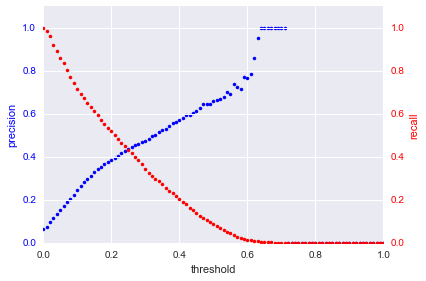

In [23]:
predicted_scores = grid_search.predict_proba(X_test)[:,1]

#Computing precision and recall by threshold
precision_list = []
recall_list = []

threshold_list = np.arange(0, 1.01, 0.01)

for threshold in threshold_list:
    
    precision, recall = predictions.calc_precision_recall(predicted_scores, y_test, threshold)
    
    precision_list.append(precision)
    recall_list.append(recall)

#Plotting the values
predictions.plot_precision_recall_threshold(threshold_list, precision_list, recall_list)

Looking at the precision-recall-curve, we can see that the precision makes a big jump when the threshold is greater than 0.6. However, recall is getting close to 0 at that point. Since we are interested in precision though, we will use __0.6 as our threshold__.

In [34]:
threshold = 0.6

predicted_values = np.zeros(len(predicted_scores))
predicted_values[predicted_scores >= threshold] = 1

X_test["predicted_scores"] = predicted_scores
X_test["predicted_values"] = predicted_values
X_test["true_val"] = y_test

X_test_sorted = X_test.sort_values("predicted_scores", ascending=False)
X_test_sorted[["predicted_values", "predicted_scores", "true_val"]].head(20)

# What is our precision for the top X entries? 
number_individuals_list = [20, 30, 50]
for number in number_individuals_list:
    
    print("Precision for first {} individuals predicted to face financial problems: {}".format(number, 
            predictions.precision_top_x(X_test_sorted["predicted_values"], X_test_sorted["true_val"], number)))

,predicted_values,predicted_scores,true_val
PersonID,,,
59129,1.0,0.711707,1
118747,1.0,0.678963,1
43949,1.0,0.675797,1
424,1.0,0.675447,1
142358,1.0,0.670417,1
43444,1.0,0.669841,1
18691,1.0,0.669738,1
11986,1.0,0.668165,1
73976,1.0,0.666590,1


Precision for first 20 individuals predicted to face financial problems: 1.0
Precision for first 30 individuals predicted to face financial problems: 0.8666666666666667
Precision for first 50 individuals predicted to face financial problems: 0.8


----
# Summary

We wanted to predict which individuals are the most likely to face financial problems in the next two years. The goal was to identify the 20 individuals that the fictive loan-lending organization should reach out to in order to discuss their situation and identify a solution to their problem.

After exploring the data and creating additional features, we conducted a cross validation (k=3) grid search to find the parameters for a random forest of 40 trees that would maximize precision. The result was a random forest with minimum samples per leaf of 10 and whose trees use max. 10% of all features when deciding on which variable to split next. It achieves a mean validation precision score of 0.635 when using 0.5 as the threshold.

We then examined the precision-recall-curve to better understand how the threshold impacts precision and recall. Based on that analysis, we chose a threshold of 0.6 to obtain a high precision. Applying our trained classifier with a threshold of 0.6 on the test set, we were able to obtain a precision of 1.0 when looking at the first 20 individuals: Of all the 20 individuals that the model found to be more likely to face financial problems, all 20 actually did face financial problems. That is good news as the loan-lending organization could use our model to pick to which 20 individuals they should reach out to.

We also examined how well our model performs on the first 30 and 50 individuals that it finds most likely to face financial problems. Even though the organization can currently only reach out to 20 individuals, if our precision is high enough, it might be worth it for them to get additional resources so that they can reach out to more individuals. The precision for the first 30 and the first 50 individuals was 0.86 and 0.8 respectively. Depending on the benefit from reaching out to the individuals and the cost associated with the additional resources, the investment might be worth it.

----
# Next Steps Ideas: Please ignore for homework grading

In [25]:
# Let's take a look at our differences.
predicted_vals = grid_search.predict(X_train)

#What was the average vote for class 1?
predictions_prob = grid_search.predict_proba(X_train)[:,1]

errors = np.absolute(predicted_vals - np.asarray(y_train))
errors_prob = np.absolute(predictions_prob - np.asarray(y_train))

prediction_comp = pd.DataFrame({'prediction': predicted_vals,
                                'predictions_prob': predictions_prob,
                                'true_y': y_train,
                                'errors': errors,
                                'errors_prob': errors_prob})
prediction_comp[prediction_comp.errors == 1][["prediction", "predictions_prob", 
                                              "true_y", "errors_prob"]].head(100)

,prediction,predictions_prob,true_y,errors_prob
PersonID,,,,
16948,0,0.364747,1,0.635253
77501,0,0.278895,1,0.721105
119903,0,0.246449,1,0.753551
96571,0,0.464243,1,0.535757
15928,0,0.400182,1,0.599818
84223,0,0.437922,1,0.562078
61178,0,0.073089,1,0.926911
69548,0,0.263851,1,0.736149
74734,0,0.191093,1,0.808907


In [26]:
# What is the best cut-off value for our prob_a?
dec_tree = tree.DecisionTreeClassifier()
fitted_tree = dec_tree.fit(prediction_comp.predictions_prob.values.reshape(-1,1), prediction_comp.true_y)

fitted_tree.score(prediction_comp.predictions_prob.values.reshape(-1,1), prediction_comp.true_y)

#What is the threshold for the first split?
fitted_tree.tree_.threshold[0]

0.99906467661691545

0.16645106673240662

In [27]:
threshold = 0.17080429196357727
prediction_comp["pred_w_threshold"] = prediction_comp.predictions_prob.apply(lambda x: 0 if x < threshold else 1)
prediction_comp.head(10)

,errors,errors_prob,prediction,predictions_prob,true_y,pred_w_threshold
PersonID,,,,,,
87936,0,0.009401,0,0.009401,0,0
3893,0,0.118166,0,0.118166,0,0
41405,0,0.072059,0,0.072059,0,0
91125,0,0.055108,0,0.055108,0,0
67373,0,0.333865,1,0.666135,1,1
89595,0,0.032005,0,0.032005,0,0
77733,0,0.182082,0,0.182082,0,1
119526,0,0.017608,0,0.017608,0,0
1789,0,0.027335,0,0.027335,0,0


In [28]:
len(prediction_comp[prediction_comp.true_y == prediction_comp.pred_w_threshold]) / len(prediction_comp)

0.9156915422885572

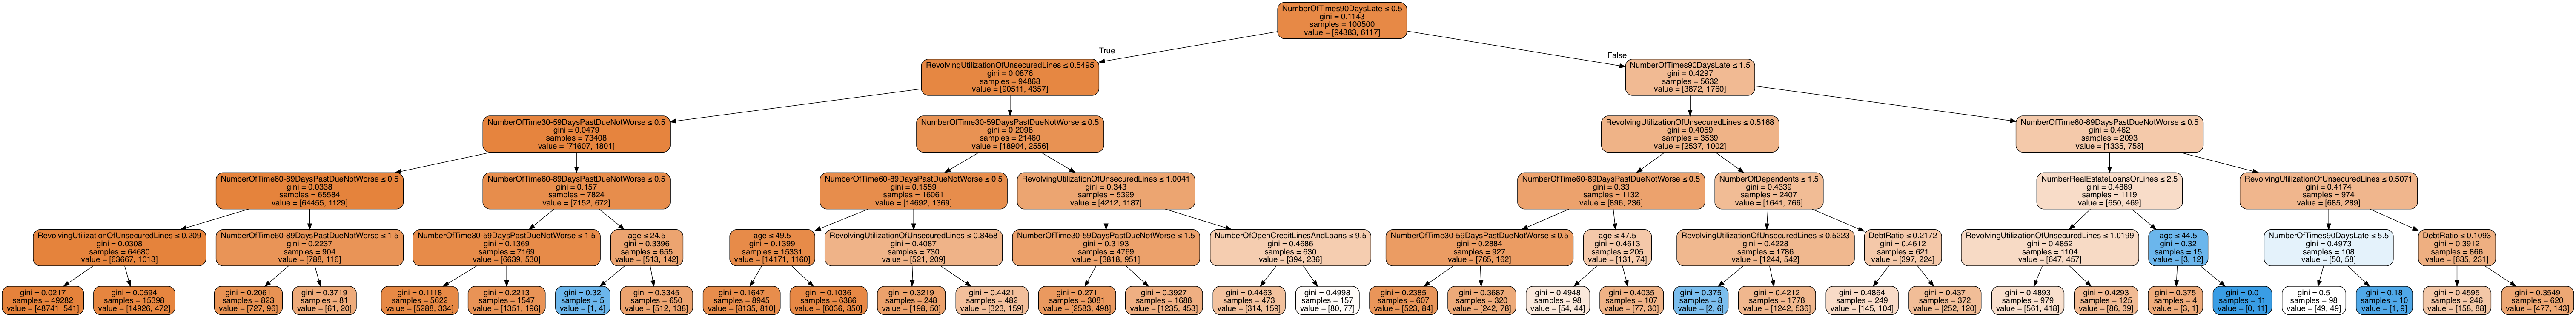

In [29]:
# Can we better understand our errors?
dec_tree = tree.DecisionTreeClassifier(max_depth=5)
fitted_tree = dec_tree.fit(X_train, prediction_comp.errors)

#Source: http://scikit-learn.org/stable/modules/tree.html
dot_data = tree.export_graphviz(fitted_tree, out_file=None, 
                         feature_names=X_train.columns,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())